# WHFast tutorial

This tutorial is an introduction to the python interface of WHFast, a fast and unbiased symplectic Wisdom-Holman integrator. The method is described in Rein & Tamayo (2015).

This tutorial assumes that you have already installed REBOUND.

**First WHFast integration**

You can enter all the commands below into a file and execute it all at once, or open an interactive shell).

First, we need to import the REBOUND module (make sure have have enabled the virtual environment if you used it to install REBOUND).

In [1]:
import rebound

Next, we create a REBOUND simulation instance. This object encapsulated all the variables and functions that REBOUND has to offer. 

In [2]:
sim = rebound.Simulation()

Now, we can add particles. We'll work in units in which $G=1$ (see [Units.ipynb](Units.ipynb) for using different units). The first particle we add is the central object. We place it at rest at the origin and use the convention of setting the mass of the central object $M_*$ to 1:

In [3]:
sim.add(m=1.)

Let's look at the particle we just added:

In [4]:
print(sim.particles[0])

<rebound.Particle object, id=-1 m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>


The output tells us that the mass of the particle is 1 and all coordinates are zero. 

The next particle we're adding is a planet. We'll use Cartesian coordinates to initialize it. Any coordinate that we do not specify in the `sim.add()` command is assumed to be 0. We place our planet on a circular orbit at $a=1$ and give it a mass of $10^{-3}$ times that of the central star.

In [5]:
sim.add(m=1e-3, x=1., vy=1.)

Instead of initializing the particle with Cartesian coordinates, we can also use orbital elements. By default, REBOUND will use Jacobi coordinates, i.e. REBOUND assumes the orbital elements describe the particle's orbit around the centre of mass of all particles added previously. Our second planet will have a mass of $10^{-3}$, a semimajoraxis of $a=2$ and an eccentricity of $e=0.1$ (note that you shouldn't change G after adding particles this way, see [Units.ipynb](Units.ipynb)):

In [6]:
sim.add(m=1e-3, a=2., e=0.1)

Now that we have added two more particles, let's have a quick look at what's in this simulation by using

In [7]:
sim.status()

---------------------------------
Rebound version:     	2.0.0
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.000000
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, id=-1 m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=1.0 y=0.0 z=0.0 vx=0.0 vy=1.0 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=1.800999001 y=0.0 z=0.0 vx=0.0 vy=0.783516306452 vz=0.0>
---------------------------------


You can see that REBOUND used the `ias15` integrator as a default. Next, let's tell REBOUND that we want to use `WHFast` instead. We'll also set the timestep. In our system of units, an orbit at $a=1$ has an orbital period of $T_{\rm orb} =2\pi \sqrt{\frac{GM}{a}}= 2\pi$. So a reasonable timestep to start with would be $dt=10^{-3}$ (see Rein & Tamayo 2015 for some discussion on timestep choices).

In [8]:
sim.integrator = "whfast"
sim.dt = 1e-3

`whfast` refers to the 2nd order symplectic integrator WHFast described by Rein & Tamayo (2015). By default, no symplectic correctors are used, but they can be easily turned on (see [Advanced Settings for WHFast](AdvWHFast.ipynb)). 

We are now ready to start the integration. Let's integrate the simulation for one orbit, i.e. until $t=2\pi$. Because we use a fixed timestep, rebound would have to change it to integrate exactly up to $2\pi$. Changing the timestep in a symplectic integrator is a bad idea, so we'll tell rebound to not worry about the `exact_finish_time`.

In [9]:
sim.integrate(6.28318530717959, exact_finish_time=0)   # 6.28318530717959 is 2*pi

Once again, let's look at what REBOUND's status is

In [10]:
sim.status()

---------------------------------
Rebound version:     	2.0.0
Number of particles: 	3
Selected integrator: 	whfast
Simulation time:     	6.452747
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, id=-1 m=1.0 x=0.00342570510646 y=0.00988382258475 z=0.0 vx=0.000659690599358 vy=0.00126370550653 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=0.984985535084 y=0.204192633157 z=0.0 vx=-0.191764855716 vy=0.981302488129 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=-1.60969164054 y=1.42056349064 z=0.0 vx=-0.467925743642 vy=-0.461491688211 vz=0.0>
---------------------------------


As you can see the time has advanced to $t=2\pi$ and the positions and velocities of *all* particles have changed. If you want to post-process the particle data, you can access it in the following way:

In [11]:
particles = sim.particles
for p in particles:
    print(p.x, p.y, p.vx, p.vy)

(0.0034257051064559545, 0.009883822584753928, 0.0006596905993581783, 0.0012637055065343893)
(0.9849855350839128, 0.20419263315743996, -0.19176485571619312, 0.9813024881286893)
(-1.6096916405408663, 1.4205634906382492, -0.46792574364198525, -0.4614916882111353)


The `particles` object is an array of pointers to the particles. This means you can call `particles = sim.particles` before the integration and the contents of `particles` will be updated after the integration. If you add or remove particles, you'll need to call `sim.particles` again.

**Visualization with matplotlib**

Instead of just printing boring numbers at the end of the simulation, let's visualize the orbit using matplotlib (you'll need to install numpy and matplotlib to run this example, see [Installation](Installation.ipynb)).

We'll use the same particles as above. As the particles are already in memory, we don't need to add them again. Let us plot the position of the inner planet at 100 steps during its orbit. First, we'll import numpy and create an array of times for which we want to have an output (here, from $T_{\rm orb}$ to $2 T_{\rm orb}$ (we have already advanced the simulation time to $t=2\pi$).

In [12]:
import numpy as np
torb = 2.*np.pi
Noutputs = 100
times = np.linspace(torb, 2.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)

Next, we'll step through the simulation. Rebound will integrate up to `time`. Depending on the timestep, it might overshoot slightly. If you want to have the outputs at exactly the time you specify, you can set the `exact_finish_time=1` flag in the `integrate` function (or omit it altogether, 1 is the default). However, note that changing the timestep in a symplectic integrator could have negative impacts on its properties.

In [13]:
for i,time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y

Let's plot the orbit using matplotlib.

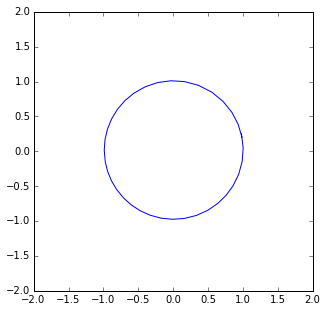

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Hurray! It worked. The orbit looks like it should, it's an almost perfect circle. There are small perturbations though, induced by the outer planet. Let's integrate a bit longer to see them. 

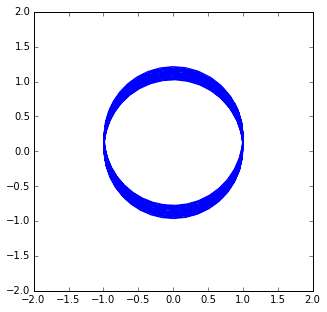

In [15]:
Noutputs = 1000
times = np.linspace(2.*torb, 20.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)
for i,time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Oops! This doesn't look like what we expected to see (small perturbations to an almost circluar orbit). What you see here is the barycenter slowly drifting. Some integration packages require that the simulation be carried out in a particular frame, but WHFast provides extra flexibility by working in any inertial frame.  If you recall how we added the particles, the Sun was at the origin and at rest, and then we added the planets.  This means that the center of mass, or barycenter, will have a small velocity, which results in the observed drift.  There are multiple ways we can get the plot we want to.
1. We can calculate only relative positions.
2. We can add the particles in the barycentric frame.
3. We can let REBOUND transform the particle coordinates to the barycentric frame for us.

Let's use the third option (next time you run a simulation, you probably want to do that at the beginning).

In [16]:
sim.move_to_com()

So let's try this again. Let's integrate for a bit longer this time.

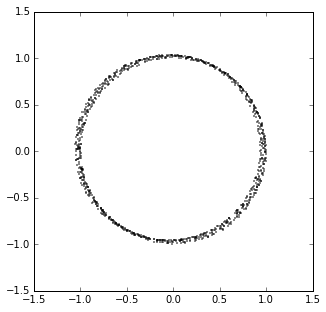

In [17]:
times = np.linspace(20.*torb, 1000.*torb, Noutputs)
for i,time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.scatter(x, y, marker='.', color='k', s=1.2);

That looks much more  like it. Let us finally plot the orbital elements as a function of time.

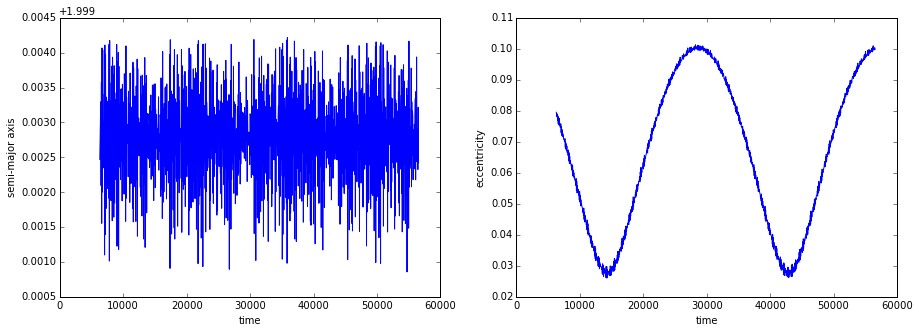

In [18]:
times = np.linspace(1000.*torb, 9000.*torb, Noutputs)
a = np.zeros(Noutputs)
e = np.zeros(Noutputs)
for i,time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    orbits = sim.calculate_orbits()
    a[i] = orbits[1].a
    e[i] = orbits[1].e
    
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(121)
ax.set_xlabel("time")
ax.set_ylabel("semi-major axis")
plt.plot(times, a);

ax = plt.subplot(122)
ax.set_xlabel("time")
ax.set_ylabel("eccentricity")
plt.plot(times, e);

The semimajor axis seems to almost stay constant, whereas the eccentricity undergoes an oscillation. Thus, one might conclude the planets interact only secularly, i.e. there are no large resonant terms.

**Speeding things up and extra accuracy**

There are several performance enhancements one can make to WHFast. However, each one has pitfalls that an inexperienced user can unwittingly fall into. We therefore chose safe default settings that make the integrator difficult to misuse. **This makes the default WHFast substantially slower and less accurate than it can be**, so anyone looking to use it more seriously should check out its advanced settings in [Advanced Settings for WHFast](AdvWHFast.ipynb).

**Common mistakes with WHFast**

If you're getting odd output, check the following:

1. The Wisdom-Holman algorithm assumes that the gravitational force on a planet from the central body dominates that from all other particles.  Therefore, if you have close approaches (that violate this approximation), you will get spurious results.  REBOUND provides an experimental hybrid integrator that switches to the IAS15 integrator for close approaches.  You can try it with `sim.integrator = "hybrid"`.  You can also check for close approaches following [Exceptions.ipynb](Exceptions.ipynb).

2.  A symplectic scheme requires a constant timestep to guarantee some of its symmetry properties.  So if you call `sim.integrate(time)`, and `time` is not a multiple of `sim.dt`, your last timestep will be different (in order to reach `time` exactly).  Therefore, if you need equally spaced outputs, you can make your output times be multiples of `sim.dt`, or if it doesn't matter, you can pass an optional flag like this: `sim.integrate(time, exact_finish_time=0)`, which will integrate to the nearest timestep. 

3.  If you're somehow modifying particles or adding forces, you should make sure to read [Advanced Settings for WHFast](AdvWHFast.ipynb).